In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import sys
import os

sys.path.append(os.path.abspath("../src"))

from regime_detection import *

### Get data and standardize features

In [2]:
# Get SP500 data
spx_data = pd.read_csv('../data/raw_data/SP500_daily.csv', index_col='Date', parse_dates=True)

# Compute returns
spx_log_returns = np.log(spx_data["Close"]).diff().dropna()
spx_log_returns = pd.DataFrame(spx_log_returns)
spx_log_returns.columns = ["log_returns"]

# Get VIX data
vix_data = pd.read_csv('../data/raw_data/VIX.csv', index_col='Date', parse_dates=True)

# Get features
features = BuildFeaturesForSJM(spx_data=spx_data, vix_data=vix_data)
features_scaled = features.get_standardized_features()

# Add log returns to features
features_scaled["log_returns"] = spx_log_returns

# Keep only data from "2000-01-01" onwards
features_scaled = features_scaled[features_scaled.index >= "2000-01-01"]

### Compute regime probabilities and short allocation

In [12]:
regime_probabilities = calculate_period_regime_probabilities(features_scaled, start=2010, end=2023)
short_allocation = calculate_short_allocation(regime_probabilities, beta_bull=0.2, beta_bear=0.5)

short_allocation

Date
2010-01-05    0.2
2010-01-06    0.2
2010-01-07    0.2
2010-01-08    0.2
2010-01-11    0.2
             ... 
2023-09-25    0.2
2023-09-26    0.2
2023-09-27    0.2
2023-09-28    0.2
2023-09-29    0.2
Length: 3445, dtype: float64

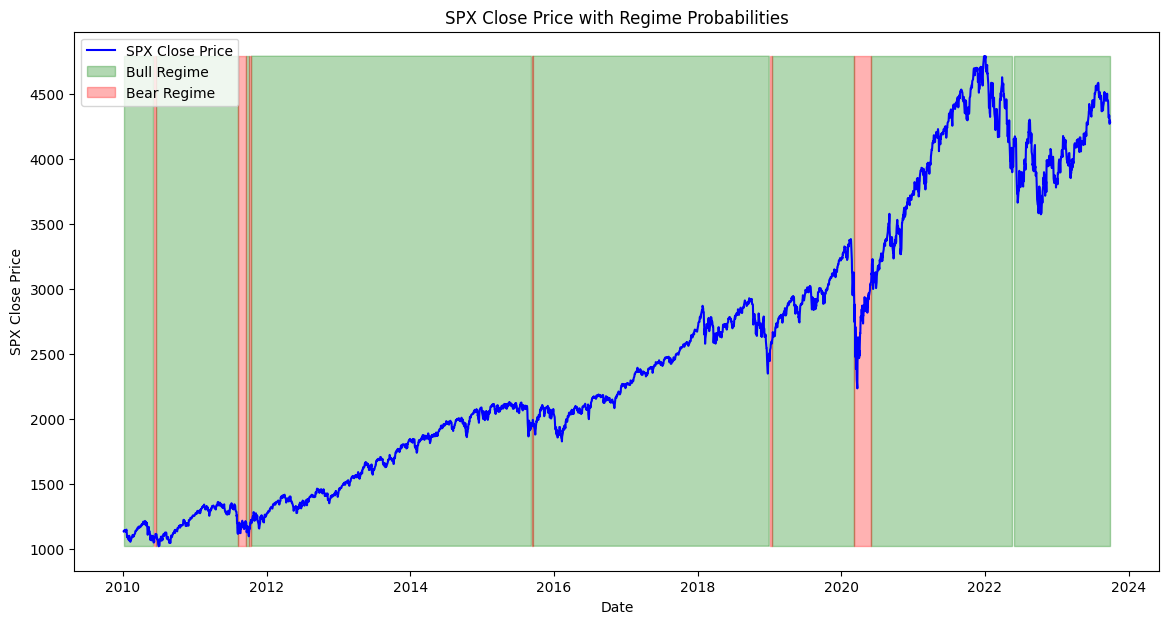

In [11]:
# Filter spx_data to match the index of regime_probabilities
spx_data_filtered = spx_data.loc[regime_probabilities.index]

# Plot SPX data
plt.figure(figsize=(14, 7))
plt.plot(spx_data_filtered.index, spx_data_filtered['Close'], label='SPX Close Price', color='blue')

# Overlay regime probabilities
bull_prob = regime_probabilities['Bull']
bear_prob = regime_probabilities['Bear']

plt.fill_between(bull_prob.index, spx_data_filtered['Close'].min(), spx_data_filtered['Close'].max(), 
                 where=bull_prob > bear_prob, color='green', alpha=0.3, label='Bull Regime')
plt.fill_between(bear_prob.index, spx_data_filtered['Close'].min(), spx_data_filtered['Close'].max(), 
                 where=bear_prob > bull_prob, color='red', alpha=0.3, label='Bear Regime')

plt.title('SPX Close Price with Regime Probabilities')
plt.xlabel('Date')
plt.ylabel('SPX Close Price')
plt.legend()
plt.show()